In [5]:

# Rows with invalid coordinates are filtered out.
# Wait times are calculated as the difference between dropoff and pickup times.
# The average wait time is calculated.
# Wait times are analyzed and plotted by hour of the day.
# The GeoJSON file for NYC boroughs is loaded, and a spatial join is performed to find the boroughs for pickup locations.
# Wait times are analyzed and plotted by borough.
# The results are saved to CSV files.
# pick up time minus drop off time _ I call that wait time - how long was the trip


{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmplm3rz6ku/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=1/part-00119-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2689-1.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmplm3rz6ku/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=2/part-00060-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2630-2.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmplm3rz6ku/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=3/part-00196-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2766-1.c000.snappy.parquet


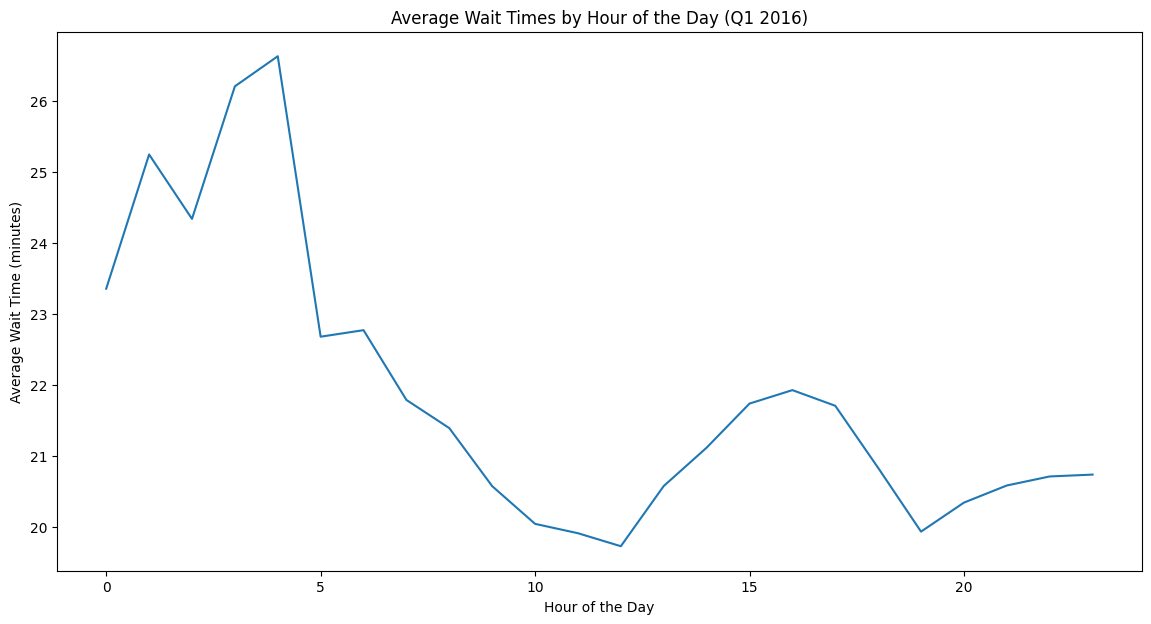

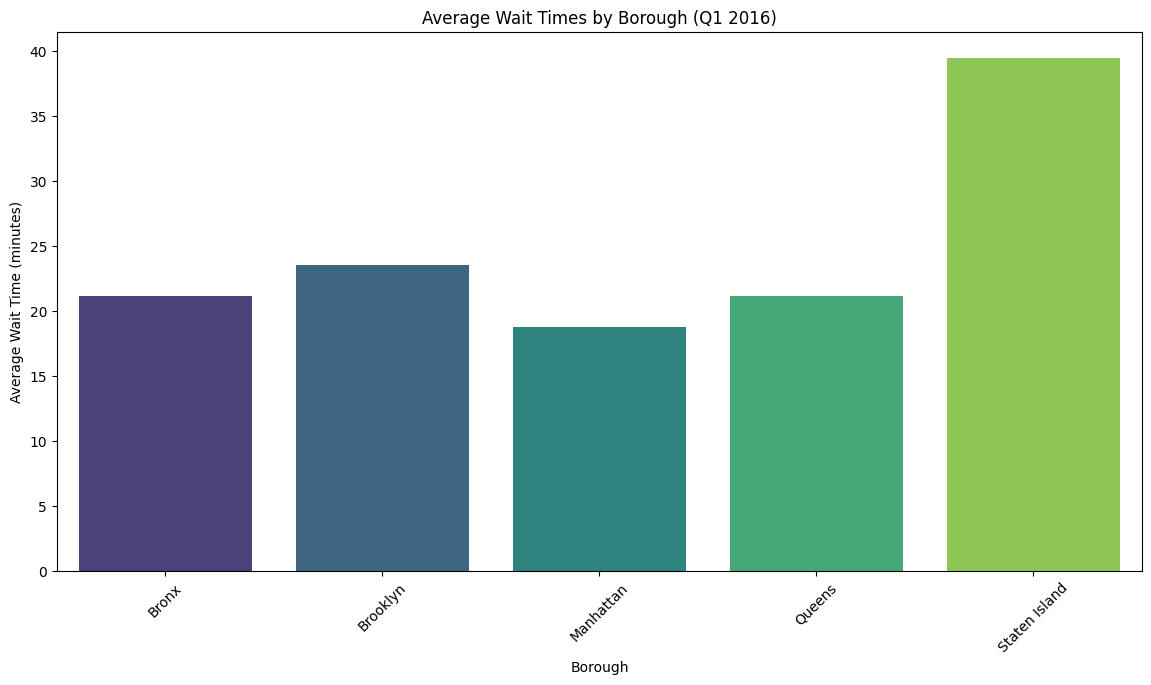

Overall average wait time: 21.39 minutes


In [3]:
# Import necessary libraries
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set the logging level to ERROR to suppress verbose logging
logging.getLogger('azureml.opendatasets').setLevel(logging.ERROR)

# Set the date range for Q1 2016
start_date = parser.parse('2016-01-01')
end_date = parser.parse('2016-03-31')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Filter out rows with invalid coordinates and create a copy to avoid SettingWithCopyWarning
nyc_tlc_df = nyc_tlc_df[(nyc_tlc_df['pickupLatitude'].between(40, 42)) & 
                        (nyc_tlc_df['pickupLongitude'].between(-75, -72)) &
                        (nyc_tlc_df['dropoffLatitude'].between(40, 42)) &
                        (nyc_tlc_df['dropoffLongitude'].between(-75, -72))].copy()

# Calculate wait times (assuming lpepDropoffDatetime is the dropoff time and lpepPickupDatetime is the pickup time)
nyc_tlc_df['wait_time'] = (nyc_tlc_df['lpepDropoffDatetime'] - nyc_tlc_df['lpepPickupDatetime']).dt.total_seconds() / 60.0

# Analyze average wait times
average_wait_time = nyc_tlc_df['wait_time'].mean()

# Analyze wait times by hour of the day
nyc_tlc_df['pickup_hour'] = nyc_tlc_df['lpepPickupDatetime'].dt.hour
wait_time_by_hour = nyc_tlc_df.groupby('pickup_hour')['wait_time'].mean()

# Plot wait times by hour of the day
plt.figure(figsize=(14, 7))
sns.lineplot(x=wait_time_by_hour.index, y=wait_time_by_hour.values)
plt.title('Average Wait Times by Hour of the Day (Q1 2016)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Wait Time (minutes)')
plt.savefig('wait_times_by_hour.png')
plt.show()

# Load the GeoJSON file for NYC boroughs and neighborhoods
boroughs_geojson_url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(boroughs_geojson_url)

# Create GeoDataFrames for pickup locations
pickup_gdf = gpd.GeoDataFrame(nyc_tlc_df, geometry=gpd.points_from_xy(nyc_tlc_df.pickupLongitude, nyc_tlc_df.pickupLatitude), crs="EPSG:4326")

# Spatial join to find the boroughs for pickup locations
pickup_gdf = gpd.sjoin(pickup_gdf, boroughs[['BoroName', 'geometry']], how='left', predicate='within')

# Analyze wait times by borough
wait_time_by_borough = pickup_gdf.groupby('BoroName')['wait_time'].mean()

# Plot wait times by borough
plt.figure(figsize=(14, 7))
sns.barplot(x=wait_time_by_borough.index, y=wait_time_by_borough.values, hue=wait_time_by_borough.index, palette='viridis', dodge=False, legend=False)
plt.title('Average Wait Times by Borough (Q1 2016)')
plt.xlabel('Borough')
plt.ylabel('Average Wait Time (minutes)')
plt.xticks(rotation=45)
plt.savefig('wait_times_by_borough.png')
plt.show()

# Save results to CSV files
wait_time_by_hour.to_csv('wait_time_by_hour.csv', header=['Average Wait Time'])
wait_time_by_borough.to_csv('wait_time_by_borough.csv', header=['Average Wait Time'])

# Display the overall average wait time
print(f"Overall average wait time: {average_wait_time:.2f} minutes")
